# The Best Neighborhood In Pittsburgh: Arrests

#### This notebook analyzes a data set of arrests in the city of Pittsburgh to determine which neighborhood is the nicest to live in. Each arrest is assigned a point value based on the crime(s) commited. After each arrest is tallied up, the neighborhoods with the lowest scores are deemed the best neighborhoods for this metric.

## Arrests

In [1]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

The first cell of code is to import the necessary data structures for the analysis of the data.

In [2]:
arrests_data = pd.read_csv("Arrests.csv")

This cell initializes the data that will be used for this analysis. Since there is so much unnecessary data in this set, it it more useful to only look at specific columns of the data.

In [3]:
print(arrests_data.iloc[:,7].head(20))
print("------------------------------------")
print("There are",len(arrests_data),"items in this data set.")

0                                    3929 Retail Theft.
1          13(a)(16) Possession of Controlled Substance
2                                    3929 Retail Theft.
3     5503 Disorderly Conduct. / 5505 Public Drunken...
4     2702 Aggravated Assault. / 2705 Recklessy Enda...
5                                    3929 Retail Theft.
6                                  2701 Simple Assault.
7     2701 Simple Assault. / 5505 Public Drunkenness...
8              903 Criminal Conspiracy. / 3701 Robbery.
9     3127 Indecent Exposure. / 3123(a)(6) IDSI with...
10    2701 Simple Assault. / 3304 Criminal Mischief....
11                                 2701 Simple Assault.
12              5507 Obstructing Highways and Passages.
13    3921(a) Theft by Unlawful Taking or Dispositio...
14    5123 Contraband. / 13(a)(16) Possession of Con...
15             903 Criminal Conspiracy. / 3701 Robbery.
16    5505 Public Drunkenness / 13(a)(32) Parapherna...
17    6106 Firearms not to be Carried without a 

The output above is the arrests data organized by offenses. There are 47277 offenses in this data set, which began tracking arrests since 2016. This program displays the first 20 offenses in the dataset. This is the first variable that is pertinent in the analysis.

In [4]:
print(arrests_data.iloc[:,9])

0                       Bloomfield
1                     Outside City
2                         Westwood
3                   East Allegheny
4                  Crafton Heights
                   ...            
47272    Central Business District
47273             Mount Washington
47274                   Upper Hill
47275               Homewood South
47276               Homewood South
Name: INCIDENTNEIGHBORHOOD, Length: 47277, dtype: object


This is the arrest data organized by neighborhood. This is the second pertinent variable is this analysis.

In [5]:
arrests_data.dropna(inplace=True,subset=["OFFENSES","INCIDENTNEIGHBORHOOD"])
print(arrests_data.iloc[:,7])

0                                       3929 Retail Theft.
1             13(a)(16) Possession of Controlled Substance
2                                       3929 Retail Theft.
3        5503 Disorderly Conduct. / 5505 Public Drunken...
4        2702 Aggravated Assault. / 2705 Recklessy Enda...
                               ...                        
47272    2701 Simple Assault. / 13(a)(31) Marijuana: Po...
47273         13(a)(16) Possession of Controlled Substance
47274                      9093 Indirect Criminal Contempt
47275                                 2701 Simple Assault.
47276                                 2701 Simple Assault.
Name: OFFENSES, Length: 45497, dtype: object


This code gets rid of all the empty cells in the "OFFENSES" and INCIDENTNEIGHBORHOOD" columns so that there are no problems during run time. If these empty slots are left in, there will be a "nan" value in its place, which complicates the code later on.

In [6]:
neighborhood = arrests_data["INCIDENTNEIGHBORHOOD"].unique()

print(neighborhood)
n_count = [0] * len(neighborhood)

new_dict = {"neighborhood":neighborhood,"count":n_count}

print(new_dict)
s = pd.DataFrame(new_dict)

s

['Bloomfield' 'Outside City' 'Westwood' 'East Allegheny' 'Crafton Heights'
 'Greenfield' 'Brookline' 'Regent Square' 'East Liberty' 'East Hills'
 'Carrick' 'Allegheny Center' 'South Side Flats' 'Sheraden'
 'East Carnegie' 'Golden Triangle/Civic Arena' 'Point Breeze North'
 'Perry South' 'Allentown' 'North Shore' 'Marshall-Shadeland'
 'Central Oakland' 'Middle Hill' 'Strip District'
 'Lincoln-Lemington-Belmar' 'Central Northside' 'Troy Hill-Herrs Island'
 'Highland Park' 'Homewood North' 'Northview Heights' 'Brighton Heights'
 'Hazelwood' 'Perry North' 'Bedford Dwellings' 'Elliott' 'Beechview'
 'Fineview' 'Glen Hazel' 'Spring Hill-City View' 'Bluff' 'Manchester'
 'Homewood West' 'Outside County' 'Point Breeze' 'Homewood South'
 'Squirrel Hill South' 'Terrace Village' 'Upper Lawrenceville' 'Arlington'
 'South Side Slopes' 'Lower Lawrenceville' 'Garfield' 'Lincoln Place'
 'Larimer' 'Mount Washington' 'California-Kirkbride' 'Banksville'
 'Bon Air' 'South Shore' 'Beltzhoover' 'Knoxville' 'C

,neighborhood,count
0,Bloomfield,0
1,Outside City,0
2,Westwood,0
3,East Allegheny,0
4,Crafton Heights,0
...,...,...
93,Ridgemont,0
94,Swisshelm Park,0
95,Hays,0
96,Chartiers City,0


## What Counts in this Data?
This is the metric upon which the arrests will be judged. All other arrests in this data set were excluded in this analysis for being too broad, not substantive, or unreflective of the neighborhood. If one of these classifications occurs twice in the same arrest, it is counted twice. 
### 1/10th of a Point
* Delivery of a Controlled Substance

### One Point
* Vandalism
* Ethnic Intimidation
* Unlawful Restraint
* Harrasment
* DUI
* Voluntary Manslaughter
* Robbery
* Simple Assault
* Terroristic Threats

### Two Points
* Stalking
* Aggrevated Assault
* Burglary 
* Threat to Use Weapons of Mass Destruction

### Three Points
* Sexual Assault
* Arson
* Homicide
* Drug Delivery Resulting in Death
* Assault By Prisoner
* Indecent Assault
* Kidnapping

### Four Points
* Murder
* Rape

### Five Points
* Terrorism

In [7]:
tenth = ["Delivery of Controlled Substance"]
one = ["Vandalism","Ethnic Intimidation","Unlawful Restraint","Harrasment","DUI","Voluntary Manslaughter","Robbery"
      "Simple Assault","Terroristic Threats"]
two = ["Stalking","Aggrevated Assault","Burlgary","Threat to Use Weapons of Mass Destruction"]
three = ["Sexual Assault","Arson","Homicide","Drug Delivery Resulting in Death","Assault By Prisoner","Kidnapping"]
four = ["rape","murder"]
five = ["terrorism"]

These arrays set up above are set up to assign point values to each of the arrests. They are used below to calculate the point values for each arrest.

In [8]:
## takes around 10 seconds to run

def addArrests(arrest_arr,value):
    for x in arrest_arr:
        mask = arrests_data["OFFENSES"].str.contains(x)
        a = arrests_data[mask]
        find_neighborhood(a.iloc[:,9],value)
                
def find_neighborhood(neigh,value):
    i = 0
    while(i < len(neigh)):
        b = 0
        while(b<len(s)):
            if s.iloc[b,0]==neigh.iloc[i]:
                s.iloc[b,1] = s.iloc[b,1] + value
                break
            b = b + 1
        i = i + 1

addArrests(tenth,.1)
addArrests(one,1)
addArrests(two,2)
addArrests(three,3)
addArrests(four,4)
addArrests(five,5)

s

,neighborhood,count
0,Bloomfield,121.4
1,Outside City,9.2
2,Westwood,32.0
3,East Allegheny,116.8
4,Crafton Heights,76.3
...,...,...
93,Ridgemont,6.0
94,Swisshelm Park,4.0
95,Hays,24.1
96,Chartiers City,11.0


The code above assigns all the point values to the neighborhoods based on the notable arrests in the neighborhood.

In [9]:
five_worst = s.nlargest(5,'count')
five_worst

,neighborhood,count
12,South Side Flats,357.8
10,Carrick,325.7
86,Central Business District,313.7
54,Mount Washington,237.8
28,Homewood North,214.7


The code above produces a dataframe of the five neighborhoods with the most dangerous arrests and environments, and the code below displays it as a bar graph. This could eliminate any neighborhoods that may do well in other categories.

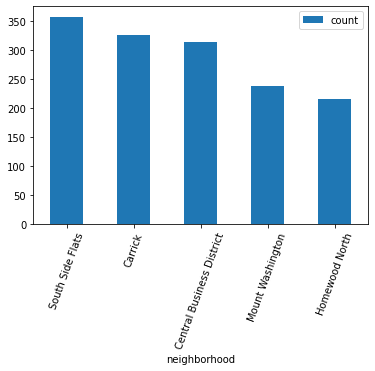

In [10]:
five_worst.plot.bar(x='neighborhood',rot=70)

In [11]:
ten_best = s.nsmallest(10,'count')
ten_best

,neighborhood,count
26,Troy Hill-Herrs Island,1.0
42,Outside County,1.0
82,Mt. Oliver Neighborhood,1.0
25,Central Northside,2.0
97,Mt. Oliver Boro,3.1
7,Regent Square,4.0
92,New Homestead,4.0
94,Swisshelm Park,4.0
78,St. Clair,5.0
72,Oakwood,6.0


The code above displays the top ten with the most dangerous arrests and environments, and the code below displays it as a bar graph. This allows the user to observe which neighboorhoods have the least amount of dangerous arrests.

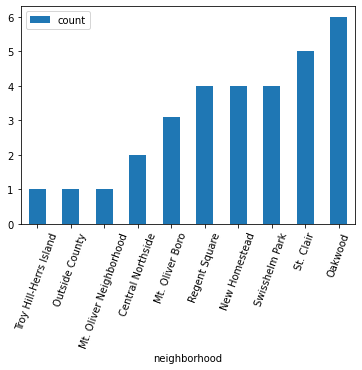

In [12]:
ten_best.plot.bar(x='neighborhood',rot=70)

The data on which neighborhood has the least amount of dangerous arrests is inconclusive. There are many neighborhoods with very low arrest values according to my analysis. In my opinion, any of the neighborhoods in the tops ten  are viable to be the best neighborhood in Pittsburgh given this data. However, South Side Flats is definitely the worst in terms of dangerous arrests, and it, along with Carrick, Central Business District, Mount Washigton, and Homewood North, does not deserve the title of best neighborhood.

# Fire Incidents within the City of Pittsburgh:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The csv file is fire incidents within the city of pittsburgh. 

Questions to answer:

What are the most frequent types of fires?

Which neighborhood has the most fires?

Which neighborhood has the least fires?

The best neighborhood is?

In [14]:
df = pd.read_csv("Fire Incidents.csv")

In [15]:
df["type_description"].value_counts()

Cooking fire, confined to container                   1797
Building fire                                         1642
Passenger vehicle fire                                 895
Outside rubbish, trash or waste fire                   604
Outside rubbish fire, Other                            430
Brush or brush-and-grass mixture fire                  410
Dumpster or other outside trash receptacle fire        360
Trash or rubbish fire, contained                       358
Special outside fire, Other                            200
Natural vegetation fire, Other                         195
Mobile property (vehicle) fire, Other                  159
Fires in structure other than in a building            113
Grass fire                                             105
Fire, Other                                             95
Outside equipment fire                                  58
Fuel burner/boiler malfunction, fire confined           52
Chimney or flue fire, confined to chimney or flue       

Above is the complete list of the different fire types and the number of times they show up. The code is simply reading the entire column of the different fire types and is counting them up for us. The results are then displayed as seen. 

Cooking fires and building fires are the most common fire types by a mile. It then drops off after those two with 
passanger vehicle fires, outside trash or waste fires, and other outside rubbish fires. 
Below is another way of looking at the above data.

The below code reads the fire incidents csv file for its data. It is turned into a variable and the variable is plotted using a bar graph.

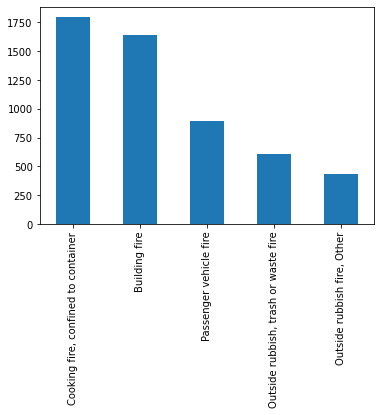

In [16]:
df = pd.read_csv("Fire Incidents.csv")

kind = df["type_description"].value_counts().head()

kind.plot.bar()

In [17]:
df["neighborhood"].value_counts()

Carrick                      237
Central Business District    213
Squirrel Hill South          211
South Side Flats             208
Hazelwood                    206
                            ... 
St. Clair                     11
Mt. Oliver                    10
East Carnegie                  8
Mount Oliver Borough           6
Regent Square                  6
Name: neighborhood, Length: 91, dtype: int64

The code above me is reading the column for neighborhoods and totaling up the amount of times each neighborhood appears in the dataset. It is then added up and displayed. This is the same thing I did above with the different fire types.

In [18]:
plot = df["neighborhood"].value_counts().tail()

This code is taking the top five neighborhoods with the least fires, and is displaying them in a bar graph.

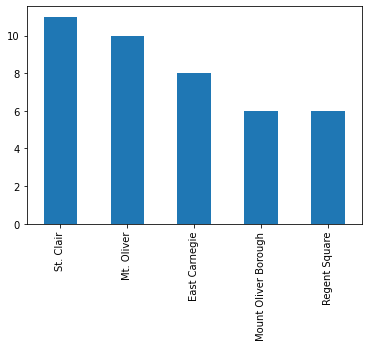

In [19]:
plot.plot.bar()

In [20]:
lot = df["neighborhood"].value_counts().head()

This code is taking the top five neighborhoods with the most fires, and is displaying them in a bar graph.

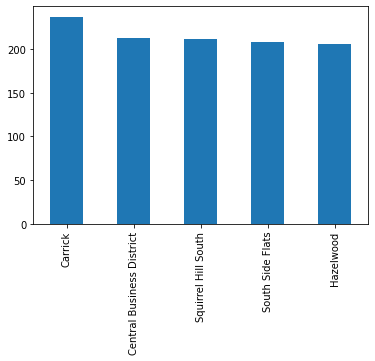

In [21]:
lot.plot.bar()

After reviewing the data, I determined that Cooking Fires, Confined to Container and Building Fires were the most frequent type of fire in the dataset. Carrick to be the worst neighborhood in Pittsburgh, has the highest number of recorded fires, and Regent Square would be the best neighborhood in Pittsburgh, has the lowest number of recorded fires. 

The best neighborhood in Pittsburgh is Regent Square


# Trees within Allegheny County

In [22]:
trees = pd.read_csv('Trees.csv') #pd.read_csv("C:/Users/gjord/Downloads/Trees.csv")
onlyTrees = trees["neighborhood"]
trees.head(10)

/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,address_number,street,common_name,scientific_name,height,width,growth_space_length,growth_space_width,growth_space_type,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,754166088,7428,MONTICELLO ST,Stump,Stump,0.0,0.0,10.0,2.0,Well or Pit,...,Homewood North,9.0,13.0,4.200313e+10,2.0,13.0,5.0,17-Mar,40.458169,-79.889724
1,1946899269,220,BALVER AVE,Linden: Littleleaf,Tilia cordata,0.0,0.0,99.0,99.0,Open or Unrestricted,...,Oakwood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,19-Jan,40.429269,-80.067868
2,1431517397,2822,SIDNEY ST,Maple: Red,Acer rubrum,22.0,6.0,6.0,3.0,Well or Pit,...,South Side Flats,3.0,16.0,4.200316e+10,3.0,16.0,3.0,24-Apr,40.426797,-79.965035
3,994063598,608,SUISMON ST,Maple: Freeman,Acer x freemanii,25.0,10.0,3.0,3.0,Well or Pit,...,East Allegheny,1.0,23.0,4.200356e+10,1.0,23.0,1.0,6-Jan,40.455503,-79.999276
4,1591838573,1135,N NEGLEY AVE,Maple: Norway,Acer platanoides,52.0,13.0,99.0,99.0,Open or Unrestricted,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,9-Mar,40.476667,-79.924106
5,1333224197,5550,BRYANT ST,Oak: Pin,Quercus palustris,45.0,18.0,35.0,3.0,Tree Lawn or Parkway,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,9-Mar,40.477496,-79.924568
6,239290336,5503,BRYANT ST,Dogwood: Corneliancherry,Cornus mas,8.0,4.0,99.0,3.0,Tree Lawn or Parkway,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,9-Mar,40.478403,-79.925985
7,1233652274,1207,KING AVE,Maple: Norway,Acer platanoides,27.0,10.0,30.0,3.0,Tree Lawn or Parkway,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,9-Mar,40.478404,-79.926126
8,1477030894,1201,KING AVE,Maple: Norway,Acer platanoides,35.0,12.0,3.0,3.0,Well or Pit,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,9-Mar,40.478314,-79.926161
9,1484901843,1456,WOODBINE ST,Maple: Norway,Acer platanoides,NaN,NaN,NaN,NaN,Open or Unrestricted,...,Stanton Heights,7.0,10.0,4.200310e+10,2.0,10.0,5.0,7-Mar,40.485240,-79.936390


In [23]:
trees.sample(10)

,id,address_number,street,common_name,scientific_name,height,width,growth_space_length,growth_space_width,growth_space_type,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
25401,867539055,258,N DITHRIDGE ST,Linden: Littleleaf,Tilia cordata,25.0,6.0,25.0,2.0,Tree Lawn or Parkway,...,North Oakland,8.0,4.0,4.200356e+10,3.0,4.0,4.0,9-Feb,40.450336,-79.952601
43199,484131623,4815,LIBERTY AVE,Stump,Stump,0.0,0.0,5.0,5.0,Well or Pit,...,Bloomfield,7.0,8.0,4.200308e+10,2.0,8.0,5.0,6-Mar,40.461445,-79.945833
18568,1288323516,1227,SPRING GARDEN AVE,Ginkgo,Ginkgo biloba,40.0,6.0,99.0,99.0,Open or Unrestricted,...,Spring Garden,1.0,24.0,4.200324e+10,1.0,24.0,1.0,5-Jan,40.460170,-79.990464
5127,1008019594,136,MONTVILLE ST,Maple: Norway,Acer platanoides,53.0,8.0,99.0,15.0,Open or Restricted,...,Summer Hill,1.0,26.0,4.200326e+10,1.0,26.0,1.0,15-Jan,40.498917,-80.015649
35368,526557189,NaN,NaN,Oak: Northern Red,Quercus rubra,0.0,0.0,0.0,0.0,Open or Unrestricted,...,Squirrel Hill South,5.0,14.0,4.200398e+10,3.0,14.0,4.0,16-Feb,40.429405,-79.900712
6582,427332958,424,DENNISTON ST,Pear: Callery,Pyrus calleryana,15.0,6.0,5.0,3.0,Well or Pit,...,Shadyside,8.0,7.0,4.200307e+10,2.0,7.0,4.0,13-Mar,40.453912,-79.920035
8562,1024692697,30,S 18TH ST,Pear: Callery,Pyrus calleryana,25.0,6.0,99.0,2.0,Tree Lawn or Parkway,...,South Side Flats,3.0,17.0,4.200317e+10,3.0,17.0,3.0,24-Apr,40.431009,-79.980604
11747,1687792521,1800,HARPSTER ST,Elm: American,Ulmus americana,20.0,9.0,8.0,3.0,Well or Pit,...,Troy Hill,1.0,24.0,4.200324e+10,1.0,24.0,1.0,2-Jan,40.465256,-79.982976
38086,618084797,NaN,NaN,Mulberry: White,Morus alba,0.0,0.0,0.0,0.0,Open or Unrestricted,...,Squirrel Hill North,5.0,14.0,4.200314e+10,3.0,14.0,4.0,8-Feb,40.437723,-79.935938
7263,1419041415,778,CASINO DR,Maple: Red,Acer rubrum,20.0,6.0,99.0,20.0,Open or Restricted,...,Chateau,6.0,21.0,4.200398e+10,6.0,21.0,1.0,8-Jan,40.447646,-80.020883


In [24]:
trees['air_quality_benfits_o3dep_dollar_value'].mean()

1.5297862609976527

***Average air quality benefits per tree ($$$)***
 = $1.529786260997632

In [25]:
trees["neighborhood"].value_counts()

Squirrel Hill South    5073
Highland Park          2941
Squirrel Hill North    2083
South Side Flats       1693
Shadyside              1558
                       ... 
Arlington Heights         5
Esplen                    3
Glen Hazel                2
South Shore               2
Hays                      1
Name: neighborhood, Length: 90, dtype: int64

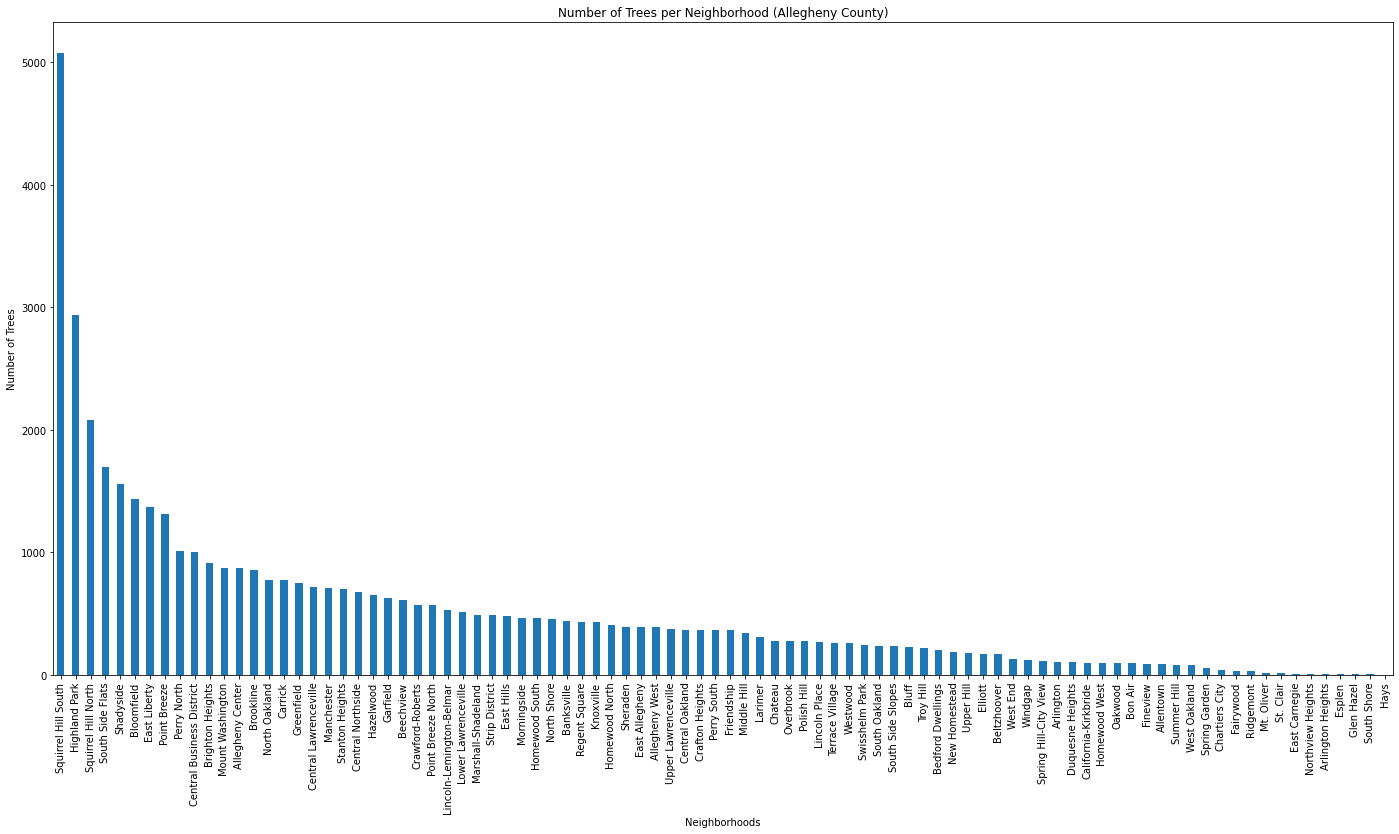

In [26]:
graph = trees["neighborhood"].value_counts().plot(kind='bar', figsize=(24,12), title = "Number of Trees per Neighborhood (Allegheny County)")
graph.set_xlabel("Neighborhoods")
graph.set_ylabel("Number of Trees")

graph

In [27]:
query_mask = trees["neighborhood"] == "Squirrel Hill South"
squirrelHillSouth = trees[query_mask]
query_mask = trees["neighborhood"] == "Highland Park"
highlandPark = trees[query_mask]
query_mask = trees["neighborhood"] == "Squirrel Hill North"
squirrelHillNorth = trees[query_mask]
query_mask = trees["neighborhood"] == "South Side Flats"
southSideFlats = trees[query_mask]
query_mask = trees["neighborhood"] == "Shadyside"
shadyside = trees[query_mask]
query_mask = trees["neighborhood"] == "Bloomfield"
bloomfield = trees[query_mask]
query_mask = trees["neighborhood"] == "East Liberty"
eastLiberty = trees[query_mask]
query_mask = trees["neighborhood"] == "Point Breeze"
pointBreeze = trees[query_mask]
query_mask = trees["neighborhood"] == "Perry North"
perryNorth = trees[query_mask]
query_mask = trees["neighborhood"] == "Central Business District"
centralBusinessDistrict = trees[query_mask]
query_mask = trees["neighborhood"] == "Brighton Heights"
brightonHeights = trees[query_mask]
query_mask = trees["neighborhood"] == "Mount Washington"
mountWashington = trees[query_mask]
query_mask = trees["neighborhood"] == "Allegheny Center"
alleghenyCenter = trees[query_mask]
query_mask = trees["neighborhood"] == "Brookline"
brookline = trees[query_mask]
query_mask = trees["neighborhood"] == "North Oakland"
northOakland = trees[query_mask]
query_mask = trees["neighborhood"] == "Carrick"
carrick = trees[query_mask]
query_mask = trees["neighborhood"] == "Greenfield"
greenfield = trees[query_mask]
query_mask = trees["neighborhood"] == "Central Lawrenceville"
centralLawrenceville = trees[query_mask]
query_mask = trees["neighborhood"] == "Manchester"
manchester = trees[query_mask]
query_mask = trees["neighborhood"] == "Stanton Heights"
stantonHeights = trees[query_mask]
query_mask = trees["neighborhood"] == "Central Northside"
centralNorthside = trees[query_mask]
query_mask = trees["neighborhood"] == "Hazelwood"
hazelwood = trees[query_mask]
query_mask = trees["neighborhood"] == "Garfield"
garfield = trees[query_mask]
query_mask = trees["neighborhood"] == "Beechview"
beechview = trees[query_mask]
query_mask = trees["neighborhood"] == "Crawford-Roberts"
crawfordRoberts = trees[query_mask]
query_mask = trees["neighborhood"] == "Point Breeze North"
pointBreezeNorth = trees[query_mask]
query_mask = trees["neighborhood"] == "Lincoln-Lemington-Belmar"
LLB = trees[query_mask]
query_mask = trees["neighborhood"] == "Lower Lawrenceville"
lowerLawrenceville = trees[query_mask]
query_mask = trees["neighborhood"] == "St. Clair"
stClair = trees[query_mask]




query_mask = trees["neighborhood"] == "Regent Square"
regentSquare = trees[query_mask]


In [28]:
print("The average CO2 savings per tree in $$$ for ALL Allegheny county ... ")
trees["co2_benefits_dollar_value"].mean()

The average CO2 savings per tree in $$$ for ALL Allegheny county ... 


0.9580760420467236

In [29]:
print("Here's some descriptive statistics about CO2 benefits per tree in lbs in Regent Square")

regentSquare["co2_benefits_totalco2_lbs"].describe()

Here's some descriptive statistics about CO2 benefits per tree in lbs in Regent Square


count     408.000000
mean      369.834479
std       359.359094
min         1.781634
25%        81.291627
50%       253.485113
75%       560.733642
max      2063.874365
Name: co2_benefits_totalco2_lbs, dtype: float64